In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

### Data & Model Parameters

In [2]:
smiles = list(fetch_smiles_gdb13('./data/gdb13/')[0])

In [3]:
params = make_params(smiles=smiles, GRU_HIDDEN_DIM=256, LATENT_DIM=128, to_file='gdb13_params.json')
#params = make_params(from_file='gdb13_params.json')

In [4]:
total_n = 100000
train_n = 100000
test_n = total_n - train_n

one_hots = to_one_hot(random.sample(smiles, total_n), params)

train_dataloader = DataLoader(one_hots[:train_n], batch_size=10, shuffle=True)
#test_dataloader = DataLoader(one_hots[train_n:], batch_size=5, shuffle=True)

print(f'total_n = {total_n}')
print(f'train_n = {train_n}')
print(f'test_n = {test_n}')

total_n = 100000
train_n = 100000
test_n = 0


### Model

In [5]:
encoder = Encoder(params)
decoder = Decoder(params)

In [6]:
#encoder.load_state_dict(torch.load('encoder_weights.pth'))
#decoder.load_state_dict(torch.load('decoder_weights.pth'))

### Train

In [7]:
LR = 0.0001
EPOCHS = 3

In [8]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LR)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

losses = []

encoder.train()
decoder.train()

for epoch_n in range(EPOCHS):
    for x in train_dataloader:
        
        # x.shape = (N, L, C)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        latents = encoder(x)
        
        y = decoder(latents, target=x)
        
        loss = criterion(y.transpose(1, 2), torch.argmax(x, dim=2))

        losses.append(float(loss))
        
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
torch.save(encoder.state_dict(), 'encoder_weights.pth')
torch.save(decoder.state_dict(), 'decoder_weights.pth')

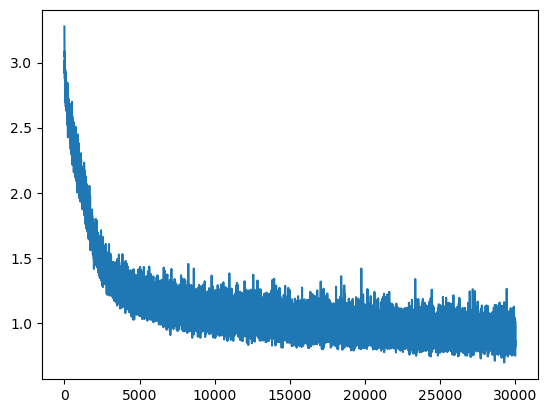

In [9]:
plt.plot(losses)

## Test

In [11]:
evaluate_ae(encoder, decoder, smiles, 1000, params=params)

torch.Size([1000, 128])


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor